In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import yaml
from cryojax.dataset import RelionParticleParameterFile, RelionParticleStackDataset
from cryojax.ndimage import irfftn, rfftn
from cryojax.ndimage.transforms import LowpassFilter

import cryojax_ensemble_optimization as cxsopt

/Data/Documents/PhD/Research/cryojax_ensemble_refinement/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Let's load the config file

In [8]:
with open("./config_data_generation.yaml", "r") as f:
    config_json = yaml.safe_load(f)
    config = dict(cxsopt.internal.DatasetGeneratorConfig(**config_json).model_dump())

In [9]:
config

{'number_of_images': 5000,
 'pixel_size': 0.2,
 'box_size': 128,
 'pad_scale': 1,
 'voltage_in_kilovolts': 10.0,
 'offset_x_in_angstroms': Array([0., 0.], dtype=float32),
 'offset_y_in_angstroms': Array([0., 0.], dtype=float32),
 'defocus_in_angstroms': Array([150., 150.], dtype=float32),
 'astigmatism_in_angstroms': Array([0., 0.], dtype=float32),
 'astigmatism_angle_in_degrees': Array([0., 0.], dtype=float32),
 'phase_shift': Array([0., 0.], dtype=float32),
 'amplitude_contrast_ratio': 0.1,
 'spherical_aberration_in_mm': 0.27,
 'ctf_scale_factor': 1.0,
 'envelope_b_factor': Array([0., 0.], dtype=float32),
 'noise_snr': Array([0.1, 0.1], dtype=float32),
 'mask_radius': 60.0,
 'mask_rolloff_width': 1.0,
 'rng_seed': 0,
 'atomic_models_params': {'path_to_atomic_models': ['atomic_models/ala_model_0.pdb',
   'atomic_models/ala_model_1.pdb'],
  'atomic_models_probabilities': Array([0.7, 0.3], dtype=float32),
  'loads_b_factors': True,
  'atom_selection': 'not element H'},
 'path_to_relion_

The image generation can be run from the command line as

`cryojax_er generate_data --config config_data_generation.yaml`

or using jupyter notebook utilities (might fail on some systems):

In [13]:
!cryojax_ensemble_optimization generate_data --config config_data_generation.yaml

/home/davidss/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


A copy of the config file and the log will be written to tutorial_data


# Visualize the images!

In [10]:
stack_dataset = RelionParticleStackDataset(
    RelionParticleParameterFile(
        path_to_starfile=config["path_to_starfile"],
        mode="r",
        loads_envelope=False,
    ),
    path_to_relion_project=config["path_to_relion_project"],
    mode="r",
)

In [11]:
lowpass_filter = LowpassFilter(
    stack_dataset[0]["parameters"]["config"].frequency_grid_in_pixels,
    frequency_cutoff_fraction=0.7,
)

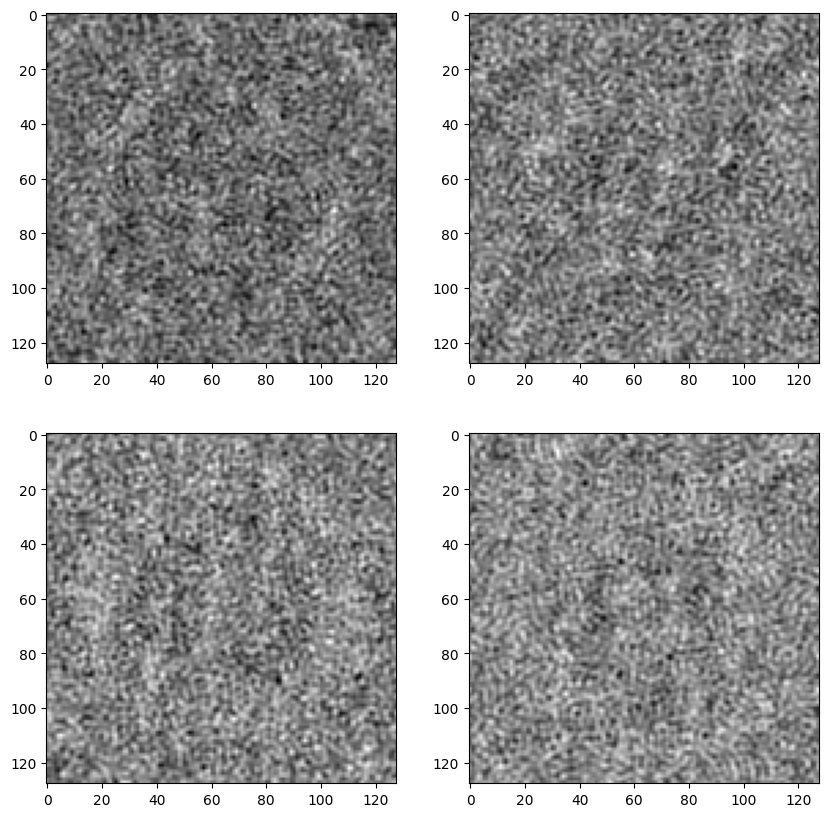

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

images = stack_dataset[0:4]["images"]
images = irfftn(lowpass_filter(rfftn(images)))

for i in range(4):
    ax.flatten()[i].imshow(images[i], cmap="gray")

## Metadata

Information about the ensemble and other parameters is saved to a metadata file

In [8]:
metadata = np.load("tutorial_data/metadata.npz")

metadata.files

['snr_per_image', 'ensemble_indices_per_image']

In [9]:
metadata["ensemble_indices_per_image"]

array([0, 0, 1, ..., 0, 1, 0], shape=(5000,), dtype=int32)

In [10]:
weight_0 = np.isclose(metadata["ensemble_indices_per_image"], 0).mean()
weight_1 = np.isclose(metadata["ensemble_indices_per_image"], 1).mean()

weight_0, weight_1

(np.float64(0.6912), np.float64(0.3088))